# ALeRCE Stamp Classifier notebook, for new DB

```Author: Rodrigo Carrasco-Davis, modifications: Ignacio Reyes, Francisco Förster. Last updated: 20221104```

For more information about the ALeRCE broker, please visit http://alerce.science/, or take a look to our presentation paper: F. Förster et al 2021 AJ 161 242 (https://doi.org/10.3847/1538-3881/abe9bc).

This notebook uses the ALeRCE API through our Python client, which can be installed with `pip install alerce`. To get the newest version you can clone and install https://github.com/alercebroker/alerce_client (use the command `python -m pip install -e .` to install). The documentation is available at https://alerce.readthedocs.io/en/latest/index.html

We recommend that you run this tutorial notebook from colab in this [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/ADASS_XXXII_Nov2022_tutorial/ALeRCE_ML_Stamp_Classifier.ipynb).

# Table of contents:
* [Introduction](#intro)
    * [Training data](#training_data) 
    * [Convolutional neural network architecture](#CNN)
    * [Classification results](#Results)
* [ALeRCE frontend and Supernova Hunter](#Front)
* [Requirements](#req)
* [ALeRCE client](#client)
    * [Plotting light curves](#plot_lc)
    * [Retrieve classified alerts](#get_alerts)
    * [Plot some examples](#examples)
    * [Get a sequence of stamps](#stamp_series)
    * [Get spatial distribution](#spatial_distribution)

# Introduction <a class="anchor" id="intro"></a>

In this notebook, we will explore the results of the ALeRCE stamp classifier, explained in **R. Carrasco-Davis et al 2021 AJ 162 231 (https://doi.org/10.3847/1538-3881/ac0ef1)**, which is based on a convolutional neural network (CNN) that uses the images and metadata of the first alert only as input. The stamp classifier uses the first alert to quickly discriminate between active galactic nuclei (AGN), supernovae(SNe), variable stars (VS), asteroids, and bogus alerts. The predictions of the classifier are used to sort the alerts by their probability of being a supernova so an astronomer can see them in the [Supernova Hunter](https://snhunter.alerce.online/) web interface, to then report the candidates to TNS. We also have a light curve based classifier **(P. Sánchez-Sáez et al 2021 AJ 161 141; https://doi.org/10.3847/1538-3881/abd5c1)**, which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band. For more information please check the AGN, Variable S

### Training Data: <a class="anchor" id="training_data"></a>
Using the labeled set from P. Sánchez-Sáez et al 2021 (The ALeRCE light curve classifier paper), we gathered 52,244 first alerts to build our training set. The number of samples of AGN, SN, VS, asteroid, and bogus are 14,966(29%), 1620 (3%), 14,996 (29%), 9899 (19%), and 10,763(20%) respectively. The images in the alert are the science, template and difference image. We noticed each of these classes can be classified fast since they present specific properties that can be found in the information of the first alert:

+ AGN: Being stochastically variable objects, an alert generated by an AGN should have flux from the source in both the reference and science stamps. Considering this feature alone, it is difficul. t to discriminate AGNs from other variable sources. Nevertheless, AGNs should lie at the centers of their host galaxies, or appear as (quasi-)stellar objects, in relatively lower stellar density fields. Thus, a change in flux will appear as a variable source, which may lie at the center of a galaxy, or even when the galaxy is not visible they tend to be in lower stellar density fields. In these cases, the alert is likely to be triggered by an AGN. In addition, AGNs are commonly found outside the Galactic plane.
    
+ Supernovae (SNe): An alert generated by a SN should appear as a change in flux where no unresolved sources were present. These transients tend to appear near their host galaxies, and their location should be consistent with the underlying host stellar population distribution (e.g., a SN will have a higher probability of arising from a location aligned with the disk than perpendicular to it). As such, most SN detections exhibit a visible host galaxy in both the science and reference stamps, with the flux from the SN arising only in the science and difference images. SN candidates tend to appear outside the Galactic plane due to occlusion.
    
+ Variable Stars (VS): The flux coming from variable stars usually appears in both the reference and science stamps. With ZTF's sensitivity, variable stars can be detected within the Milky Way or the Local Group, and thus the alert will typically not be associated with a visible host galaxy in the stamp, but rather with other point-like sources. In addition, such alerts will have a higher probability of residing at lower Galactic latitudes and in crowded fields with multiple point sources within the stamps, given the high concentration of stars in the disk and bulge of our Galaxy.

+ Asteroids: Alerts from moving Solar-system objects will appear only one time at a given position, and thus will show flux only in the science and difference images. Depending on their distance and speed, they may appear elongated in the direction of motion. In addition, such alerts should have a higher probability of residing near the ecliptic.
    
+ Bogus alerts: Camera and telescope optics effects, such as saturated pixels at the centers of bright sources, bad columns, hot pixels, astrometric misalignment in the subtraction to compute the difference image, unbaffled internal reflections, etc., can produce bogus alerts with no interesting real source. Bogus alerts are characterized by the presence of NaN pixels due to saturation, single or multiple bright pixels with little or no spatial extension (i.e., smaller than the telescope point spread function (PSF) and nightly seeing), or lines with high or low pixel values that extend over a large portion of the stamp (hot or cold columns/rows).

<img src="figures/ml/class_samples.png" width=90% />

Here we show examples of the five classes that are to be discriminated by using only the first detection. For each class, the triplet of images in each row are science, reference and difference images from left to right. Each row corresponds to a different candidate. The images are cropped at the center resulting in 21x21 images, and normalized. Further details about the pre-processing of the images is explained in Carrasco-Davis et al 2021.

### Convolutional neural network architecture: <a class="anchor" id="CNN"></a>

<table><tr><td><img src="figures/ml/cnn_architecture.png"></td><td><img src="colab/figures/ml/cnn_table.png"></td></tr></table>

The Figure on the left represent the stamp classifier. The box Convolutional Layers refers to those described in the Table at the right side, from the first convolutional layer to the last pooling layer. For each sample, the science, reference and difference images are concatenated in the channel dimension, obtaining an image input of dimension $21 \times 21 \times 3$. For each sample within the sampled batch, rotated versions are generated and fed to the CNN. After the first dense layer, the dense vectors of each the rotated version for the same objects are averaged. The metadata features pass through a batch normalization layer, the output of which is concatenated with the cyclic pooling output. Then, the concatenation goes through 2 fully connected layers, and finally a softmax function is applied to estimate the output probabilities. For the convolutional layers, the parameters shown in the table at the right are the filter dimensions and number of output channels. All the convolutional layers and fully connected layers have a Recified Linear Unit (ReLU) activation function (except for the last fully connected one that has a softmax output).

When the CNN model is trained using cross-entropy as the loss function to be minimized, the classification confidence of the model is very high, resulting in a distribution of output probabilities with saturated values of 0s and 1s without populating the values in between, even for wrong classifications. In this case there is no insight of certainty (relative probabilities between classes) of the prediction because most estimated probabilities for each class were either 0 or 1. In order to provide more granularity to the astronomers who revise SN candidates reported by the model to later request follow-up observing time, we added the entropy of the predicted probabilities of the models as a regularization term, to be maximized during training. By maximizing the entropy of the output probabilities, we penalize predictions with high confidence, in order to get better insight in cases where the stamps seem equally likely to belong to more than one class. The loss function $\mathcal{L}$ per sample is as follows:

$$    \mathcal{L} = \underbrace{-\sum_{c=1}^{N}y_{c}\log{(\hat{y}_{c})}}_{\text{cross-entropy}} + \underbrace{\beta \sum_{c=1}^{N}\hat{y}_{c}\log{(\hat{y}_{c})}}_{\text{entropy regularization}},$$
where $N$ is the number of classes, $y_{c}$ is the one-hot encoding label (a value of 1 in the corresponding index of class, and 0 for the rest)  indexed by $c$, $\hat{y}_{c}$ is the model prediction for class $c$, and $\beta$ controls the regularization term in the loss function.

### Clasification results: <a class="anchor" id="Results"></a>

<table><tr><td><img src="figures/ml/cm.png"></td><td><img src="colab/figures/ml/betas.png"></td></tr></table>

In the left image we show the confusion matrix in the test set for the proposed model. We use accuracy to compare models since the validation and test sets are balanced; achieving $0.95 \pm 0.005$ in the validation set and $0.941 \pm 0.004$ in the test set. To compute the confusion matrix we run five realizations of the mentioned model. With our five class model, we recover $87 \pm 1\%$ of the SNe, with only $5 \pm 2\%$ of false positives. By inspecting the predictions made by our model for each SN sample in the test set, we found that the results are in agreement with our initial expectations regarding the class discrimination described in the Training Data section. It is worth highlighting that the results of our model are achieved by using **the first alert only**.

In the right image, we show the probability distribution for each of the classes in the training set, for different values of the regularization constant $\beta=\{ 0, 0.5, 1.0 \}$. For the model without regularization ($\beta = 0$ shown on the top plot), the probability distribution saturates to 1 or 0. Increasing $\beta$ to 0.5 or 1.0 decreases the saturation and spreads the distribution of predictions made by the model (mid and bottom plots). In the case of $\beta=0$, the predictions are mostly saturated around 0 or 1 for the SN, VS, Asteroids and Bogus alert classes, creating difficulties to identify stamps that seem equally likely to belong to more than one class, because every sample is mapped to similar levels of high certainty. As the value of $\beta$ increases, the saturation of predicted values decreases, spreading the predicted probability distributions and emphasizing the different levels of certainty between predictions of different samples. The use of regularization to find noticeable differences in the predicted probabilities are helpful to experts for evaluating the output of the classifier, gaining better insight into how reliable the classifications are.

# ALeRCE frontend and Supernova Hunter <a class="anchor" id="Front"></a>

The [Supernova Hunter](https://snhunter.alerce.online/) is a visualization tool that allows the user to inspect SN candidates classified by the model in real time, in order to select good targets for follow-up observations.

<img src="figures/ml/sn_hunter.png" width=90% />

On the bottom left side, the location of each candidate in sky coordinates with respect to the Galactic plane and the ecliptic are depicted. On the bottom right side, a selection of the top candidates is listed, initially ordered by SN probability score from the stamp classifier. The list of candidates can be sorted by other parameters, and updated/refreshed to include newly ingested alerts. On the top left side, the SN candidate ID is shown as a clickable link to the [ALeRCE frontend](https://alerce.online/object/ZTF20abpvolc), with relevant metadata such as radec coordinates, magnitude, date, etc. At the bottom there are links to other sources of information, including ALeRCE, NED, TNS, and the Simbad Astronomical Database. In the middle of the figure there is a colored image from Aladin. On the top right side, the stamps of the first detection are shown, along with buttons for reporting the candidate as eventual bogus or as a possible SN.

<img src="figures/ml/alerce_frontend.png" width=90% />

When the candidate is inspected using the [ALeRCE frontend](https://alerce.online/object/ZTF20abpvolc), the full prediction of classes by the stamp classifier is shown at the bottom in addition to the full information of the light curve available, metadata, cross matches, etc. When the light curve of the object has six or more points in one of the bands, it is classified by the light curve classifier (Sánchez-Sáez et al. 2021), with the prediction also available in the ALeRCE frontend with a more complex taxonomy.

# Requirements <a class="anchor" id="req"></a>

In [1]:
from IPython.display import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import ephem
import astropy.units as units
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import copy
import pickle
import matplotlib.cm as cm

# ALeRCE client <a class="anchor" id="client"></a>

Install and import the ALeRCE Python client with `pip install alerce`

In [ ]:
!pip install alerce

In [2]:
from alerce.core import Alerce
client = Alerce()

### Plotting light curves <a class="anchor" id="plot_lc"></a>

We will create a simple function that plots the light curve given an object id (oid), a dataframe with detections and a dataframe with non detections. This function will be used to plot light curves of some objects predicted by the stamp classifier.

In [3]:
def plotLC(oid, SN_det, SN_nondet):
    
    colors = {1: '#56E03A', 2: '#D42F4B'} 
    fig, ax = plt.subplots(figsize = (14, 7))
    fig.set_facecolor('white')
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf, 
                yerr = SN_det[mask].sigmapsf, c=colors[fid], label=labels[fid], marker=markers[fid])
        
        # plot non detections if available
        if len(SN_nondet) != 0:
            mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
            if np.sum(mask) > 0:     
                # non detections index is mjd
                ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c=colors[fid], alpha = 0.5,
                    marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])

    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

def getObjectData(oid, doLC=False, dostamp=False):

    results = {"oid": oid}
        
    # query detections
    SN_det = client.query_detections(oid, format='pandas')
    SN_det = SN_det.sort_values("mjd")
    results["lc_det"] = SN_det
        
    # query non detections
    SN_nondet = client.query_non_detections(oid, format='pandas')
    if len(SN_nondet)!=0:
        SN_nondet = SN_nondet.sort_values("mjd")
        results["lc_nondet"] = SN_nondet
    
    # plot the LC
    if doLC:
        plotLC(oid, SN_det, SN_nondet)
        
    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = client.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        fig.set_facecolor('white')
        for idx, im in enumerate([np.arcsinh(science), np.arcsinh(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace = 0, hspace = 0)
        
    # return data
    return results

# Classified Alerts <a class="anchor" id="get_alerts"></a>

### Get objects per class
Here, we build a function that uses the ALeRCE client to query objects according to the predictions of the stamp classifier. In order to select the classifier, we define the query in terms of the classifier name, corresponding class and their minimum probability, the classes are the following strings:
+ "AGN": Active Galactic Nuclei
+ "SN": Supernova
+ "VS": Variable star
+ "Asteroid"
+ "Bogus"

Using the ALeRCE client we can select the min and max number of observations per object, also sort them by firstmjd, number of observations (ndet), probability of the selected class, etc. 

In [109]:
def get_objects_per_class(classearly="SN", pclassearly=0.8, n_objects=100):

    min_firstmjd = Time("2022-06-01T00:00:00", format="isot", scale="utc").mjd

    objects = client.query_objects(classifier="stamp_classifier",
                                   class_name=classearly,
                                   #classifier_version="stamp_classifier_1.0.4",
                                   probability=pclassearly,
                                   ranking=1,
                                   #ndet=[1, 50],
                                   #order_by="probability",
                                   #order_mode="DESC",
                                   count=False,
                                   first_mjd=[min_firstmjd, None],
                                   page_size=n_objects, 
                                   format='pandas')
    print(objects.shape)
    objects.head()
    objects.set_index("oid", inplace=True)
    objects.sort_values(by="ndet", inplace=True, ascending=False)
    return objects

The previous function returns a pandas dataframe with a list of objects by their ZTF oid as index, and relevant information in their columns as we will see next.
Now, let's query some objects for each of the classes available from the stamp classifier. Here, we are querying a few thousands of objects from the ALeRCE database. We will also sort the classes by ascending number of observations in the cases of bogus and asteroids in order to get a clean example. AGNs, VS and SNe are sorted in descending order of number of observations to better appreciate the light curves for each of these classes.

**This query will take a few seconds**

In [110]:
n_objects = 2000 # Objects per class to query
early_classes = ["AGN", "SN", "VS", "asteroid", "bogus"] # Class identifiers to query objects
objects = {} # Initialize dictionary to use the results per class
min_nobs = 1
for i, cl in enumerate(early_classes):
    print(cl)
    objects[cl] = get_objects_per_class(classearly=cl, n_objects=n_objects)
    if i==0:
        print("Result of a query using the ALeRCE client")
        display(objects[cl].head())
        print("Columns available", objects[cl].columns)

AGN
(2000, 23)
Result of a query using the ALeRCE client


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aadglas,894,3820,58323.25,59789.25,True,False,250,-0.082300,0.340824,0.177521,...,59789.283275,1308.774201,232.801159,72.940971,0.000234,0.000067,AGN,stamp_classifier,0.823811,dev
ZTF19adhcjaa,656,3028,58306.25,59870.25,True,False,177,-0.247300,0.134647,-0.145422,...,59870.125069,196.822604,253.842684,61.793150,0.000081,0.000044,AGN,stamp_classifier,0.802518,1.1.6
ZTF19aaapkgr,477,2572,58303.25,59787.25,True,False,156,0.039467,0.220362,0.114823,...,59787.238414,1310.709653,224.537279,59.415516,0.000114,0.000048,AGN,stamp_classifier,0.833062,dev
ZTF20abmdocw,184,1145,58639.50,59882.25,True,False,154,0.297400,0.196747,0.154061,...,59882.239398,837.776782,22.771191,25.883830,0.000065,0.000062,AGN,stamp_classifier,0.802477,1.1.6
ZTF20abnuzlv,341,1675,58426.25,59870.25,True,False,154,-0.002800,0.109551,-0.026476,...,59870.299086,839.828924,22.314079,41.790150,0.000058,0.000049,AGN,stamp_classifier,0.807581,1.1.6


Columns available Index(['ndethist', 'ncovhist', 'mjdstarthist', 'mjdendhist', 'corrected',
       'stellar', 'ndet', 'g_r_max', 'g_r_max_corr', 'g_r_mean',
       'g_r_mean_corr', 'firstmjd', 'lastmjd', 'deltajd', 'meanra', 'meandec',
       'sigmara', 'sigmadec', 'class', 'classifier', 'probability',
       'step_id_corr'],
      dtype='object')
SN
(2000, 23)
VS
(2000, 23)
asteroid
(2000, 23)
bogus
(2000, 23)


# Plot some examples per class <a class="anchor" id="examples"></a>

Now we have a dataframe per class resulting from our queries. The following function is just to simplify the inspection of candidates by printing the URL to the ALeRCE frontend, and call the getObjectData function done previously with the flags doLC and dostamp True to plot everything.

In [111]:
def plot_some_LC(df, n_examples=3):
    for i in range(n_examples):
        object_id = df.iloc[i].name
        print(f"https://alerce.online/object/{object_id}")
        getObjectData(object_id, doLC=True, dostamp=True)
        plt.show()

######### AGN class #########
AGN


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aadglas,894,3820,58323.25,59789.25,True,False,250,-0.082300,0.340824,0.177521,...,59789.283275,1308.774201,232.801159,72.940971,0.000234,0.000067,AGN,stamp_classifier,0.823811,dev
ZTF19adhcjaa,656,3028,58306.25,59870.25,True,False,177,-0.247300,0.134647,-0.145422,...,59870.125069,196.822604,253.842684,61.793150,0.000081,0.000044,AGN,stamp_classifier,0.802518,1.1.6
ZTF19aaapkgr,477,2572,58303.25,59787.25,True,False,156,0.039467,0.220362,0.114823,...,59787.238414,1310.709653,224.537279,59.415516,0.000114,0.000048,AGN,stamp_classifier,0.833062,dev
ZTF20abmdocw,184,1145,58639.50,59882.25,True,False,154,0.297400,0.196747,0.154061,...,59882.239398,837.776782,22.771191,25.883830,0.000065,0.000062,AGN,stamp_classifier,0.802477,1.1.6
ZTF20abnuzlv,341,1675,58426.25,59870.25,True,False,154,-0.002800,0.109551,-0.026476,...,59870.299086,839.828924,22.314079,41.790150,0.000058,0.000049,AGN,stamp_classifier,0.807581,1.1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aargkrb,1,977,59761.50,59761.50,True,True,1,NaN,NaN,NaN,...,59761.412164,0.000000,348.723055,9.144908,NaN,NaN,AGN,stamp_classifier,0.813447,1.1.2
ZTF22abchjow,10,2107,59052.50,59814.25,True,True,1,NaN,NaN,NaN,...,59814.332060,0.000000,347.140274,24.486898,NaN,NaN,AGN,stamp_classifier,0.822428,dev
ZTF22aapzkcl,1,989,59758.50,59758.50,True,True,1,NaN,NaN,NaN,...,59758.404931,0.000000,331.630223,-1.409466,NaN,NaN,AGN,stamp_classifier,0.801235,1.1.2


https://alerce.online/object/ZTF19aadglas


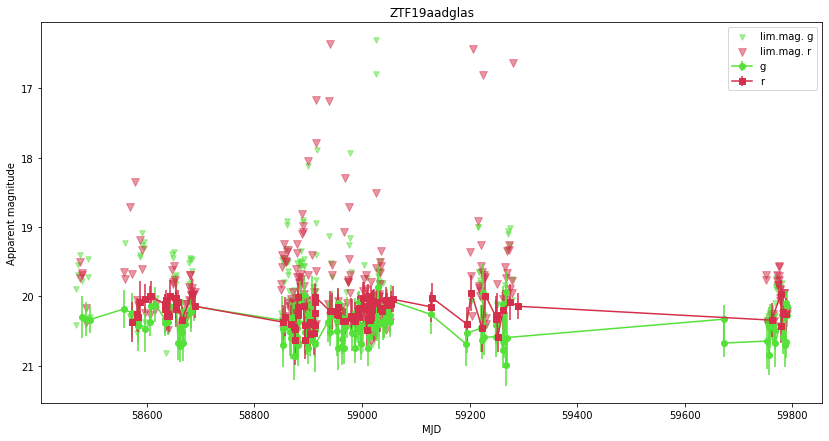

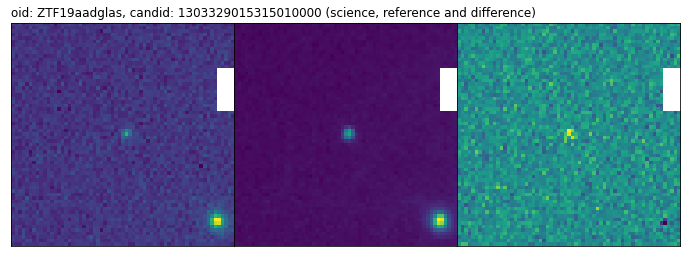

https://alerce.online/object/ZTF19adhcjaa


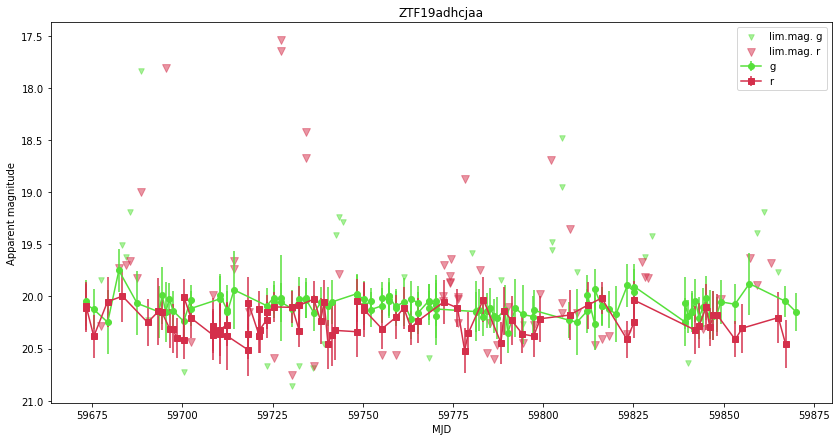

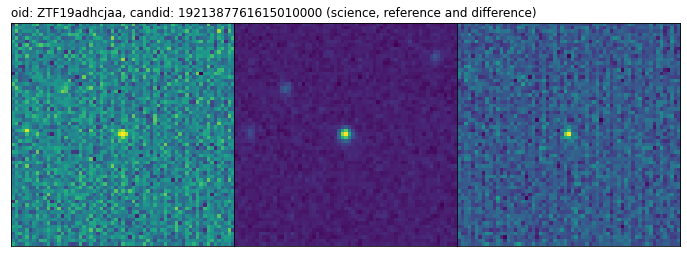

######### SN class #########
SN


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aazcuno,1126,1605,58244.500000,59883.000000,True,False,649,0.314046,0.485420,0.714248,...,59883.117859,1604.713113,297.198328,48.873275,0.000054,0.000041,SN,stamp_classifier,0.813209,1.1.6
ZTF18abjovdz,631,1014,58247.500000,59869.250000,True,False,349,-0.016772,0.327414,0.429809,...,59869.128796,1544.730556,313.829405,0.538509,0.000034,0.000033,SN,stamp_classifier,0.840184,1.1.6
ZTF18acbwagb,421,1138,58249.250000,59884.500000,False,False,279,0.169925,0.077336,0.194111,...,59884.516516,1461.043935,170.318873,76.680469,0.000269,0.000059,SN,stamp_classifier,0.846058,1.1.6
ZTF18aaxkqgy,1129,2898,58203.500000,59887.250000,True,False,273,0.182433,0.342594,0.515004,...,59887.157882,1617.839826,277.738768,29.879797,0.000027,0.000035,SN,stamp_classifier,0.811458,1.1.6
ZTF18abncsdn,560,1124,58310.500000,59883.250000,True,False,270,0.403352,-0.807142,0.717229,...,59883.128403,1534.760972,347.399275,5.586698,0.000050,0.000059,SN,stamp_classifier,0.809043,1.1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19abqqspa,1,76,58715.377384,58715.377384,False,False,1,NaN,NaN,NaN,...,58715.377384,0.000000,357.538636,-1.017204,NaN,NaN,SN,stamp_classifier,0.816388,corr_bulk_0.0.1
ZTF19abfibzo,1,136,58673.448009,58673.448009,False,False,1,NaN,NaN,NaN,...,58673.448009,0.000000,16.379540,-5.402328,NaN,NaN,SN,stamp_classifier,0.810154,corr_bulk_0.0.1
ZTF19abqhuuq,1,846,58714.181377,58714.181377,False,False,1,NaN,NaN,NaN,...,58714.181377,0.000000,296.960133,55.399839,NaN,NaN,SN,stamp_classifier,0.822500,corr_bulk_0.0.1


https://alerce.online/object/ZTF18aazcuno


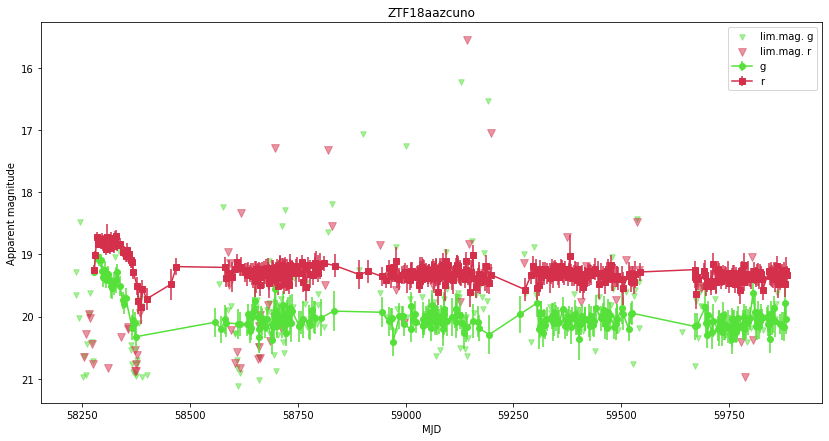

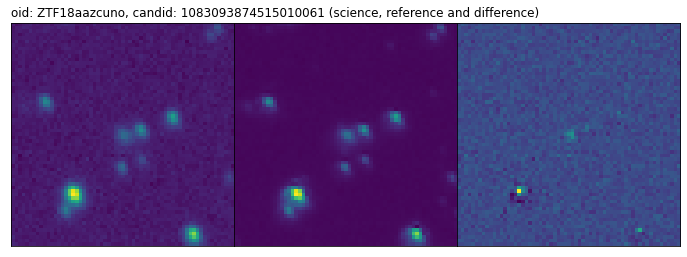

https://alerce.online/object/ZTF18abjovdz


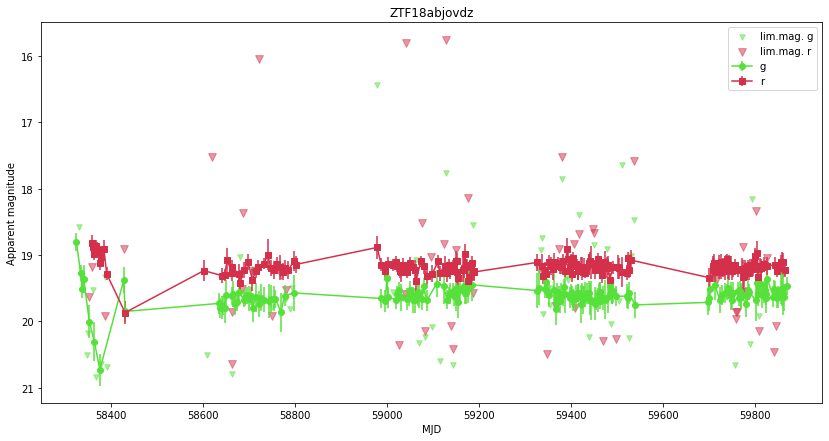

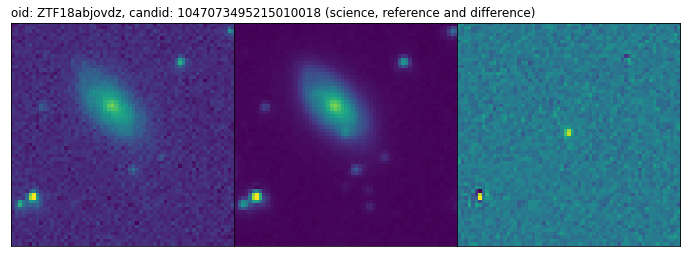

######### VS class #########
VS


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaejbn,656,1374,58095.000000,59881.250000,True,False,741,0.868800,0.989458,0.932722,...,59881.329248,1517.064445,350.250551,41.126771,0.000104,0.000122,VS,stamp_classifier,0.825711,1.1.6
ZTF17aabvpil,1014,1691,58095.250000,59887.250000,True,False,735,0.809889,0.947135,0.907481,...,59887.258113,1511.803750,66.903405,71.522373,0.000190,0.000084,VS,stamp_classifier,0.822779,1.1.6
ZTF17aabvebf,896,1744,58095.000000,59883.250000,True,False,635,0.555592,0.654461,0.544757,...,59883.133160,1533.749595,341.257088,50.371379,0.000083,0.000053,VS,stamp_classifier,0.817673,1.1.6
ZTF17aabpqda,632,1647,58095.000000,59883.250000,True,False,634,0.642493,0.584116,0.558231,...,59883.139329,1579.768901,317.294302,36.222402,0.000101,0.000071,VS,stamp_classifier,0.800945,1.1.6
ZTF17aabumbt,735,1355,58095.000000,59883.250000,True,False,625,0.479142,0.519553,0.452417,...,59883.174745,1531.867546,301.320080,52.048235,0.000080,0.000060,VS,stamp_classifier,0.807015,1.1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abdigia,42,2470,58284.471724,58999.449387,True,True,1,NaN,NaN,NaN,...,58999.449387,0.000000,359.540919,65.647212,NaN,NaN,VS,stamp_classifier,0.842316,corr_bulk_0.0.1
ZTF19aauzgfx,1,30,58617.417407,58617.417407,True,True,1,NaN,NaN,NaN,...,58617.417407,0.000000,283.303655,-6.559715,NaN,NaN,VS,stamp_classifier,0.801890,corr_bulk_0.0.1
ZTF19aaylsep,1,427,58643.275683,58643.275683,True,True,1,NaN,NaN,NaN,...,58643.275683,0.000000,278.077614,-18.348185,NaN,NaN,VS,stamp_classifier,0.810014,corr_bulk_0.0.1


https://alerce.online/object/ZTF17aaaejbn


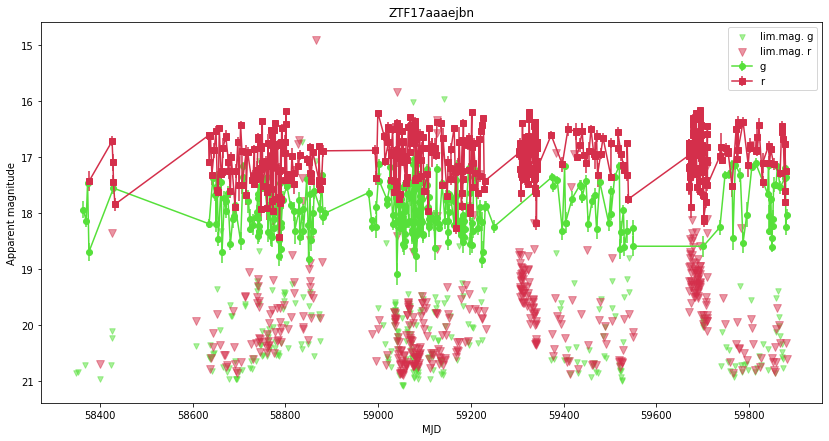

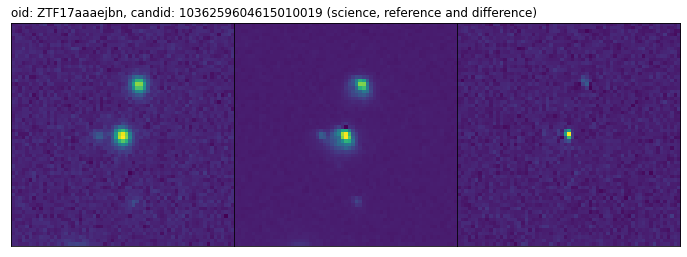

https://alerce.online/object/ZTF17aabvpil


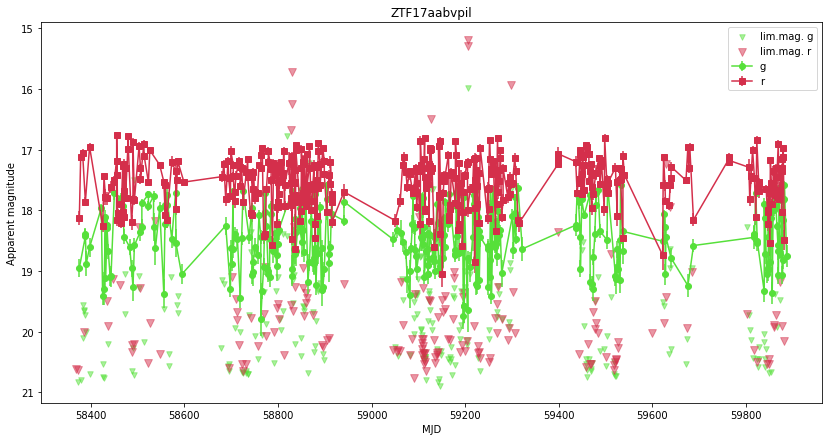

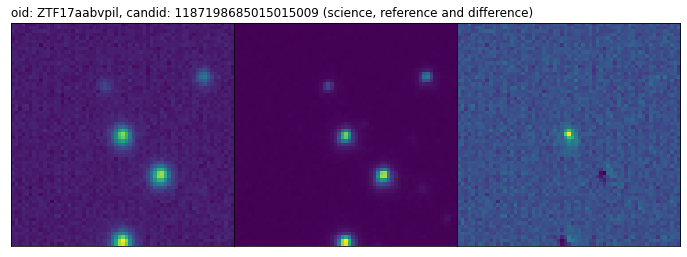

######### asteroid class #########
asteroid


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19abjpgxj,8,108,58693.444375,58704.495648,True,True,8,0.042133,0.044416,0.071640,...,58704.495648,11.051273,58.891392,29.364056,0.000008,0.000010,asteroid,stamp_classifier,0.806455,corr_bulk_0.0.1
ZTF18aadjygz,4,389,58427.362130,58846.237245,True,True,4,0.232342,0.460756,0.620228,...,58846.237245,418.875116,99.985638,38.487427,0.000080,0.000112,asteroid,stamp_classifier,0.816658,corr_bulk_0.0.1
ZTF19aaxqapd,1,182,58640.213738,58640.213738,False,False,2,NaN,NaN,NaN,...,58640.213738,0.001354,185.046240,1.056379,0.000166,0.000029,asteroid,stamp_classifier,0.821086,corr_bulk_0.0.1
ZTF19abqacwm,2,152,58712.423762,58757.328935,False,False,2,NaN,NaN,NaN,...,58757.328935,44.905174,14.800163,25.491570,0.000267,0.000080,asteroid,stamp_classifier,0.803763,corr_bulk_0.0.1
ZTF19abdqinb,2,147,58668.373819,58668.374271,False,False,2,NaN,NaN,NaN,...,58668.374271,0.000451,333.817429,3.946517,0.000015,0.000043,asteroid,stamp_classifier,0.807299,corr_bulk_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19aarjinp,1,89,58596.273553,58596.273553,False,False,1,NaN,NaN,NaN,...,58596.273553,0.000000,197.142101,2.494395,NaN,NaN,asteroid,stamp_classifier,0.813012,corr_bulk_0.0.1
ZTF19aarhpui,1,146,58594.169363,58594.169363,False,False,1,NaN,NaN,NaN,...,58594.169363,0.000000,125.154821,14.245563,NaN,NaN,asteroid,stamp_classifier,0.819971,corr_bulk_0.0.1
ZTF19aarhmzm,1,142,58594.157349,58594.157349,False,False,1,NaN,NaN,NaN,...,58594.157349,0.000000,164.585678,19.847789,NaN,NaN,asteroid,stamp_classifier,0.833047,corr_bulk_0.0.1


https://alerce.online/object/ZTF19abkczsx


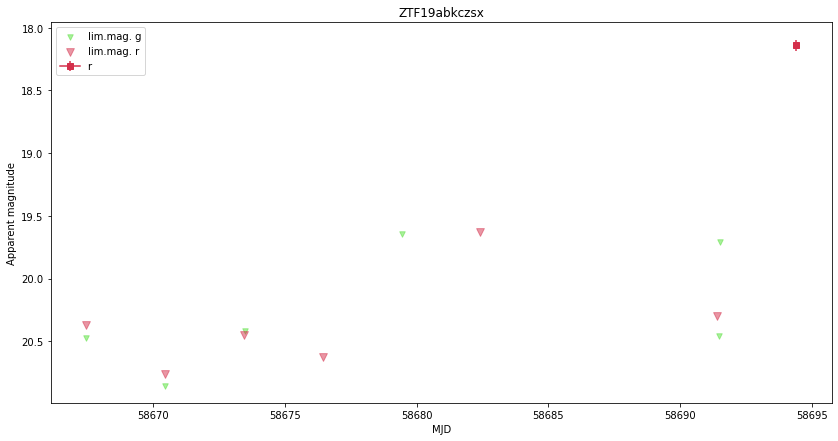

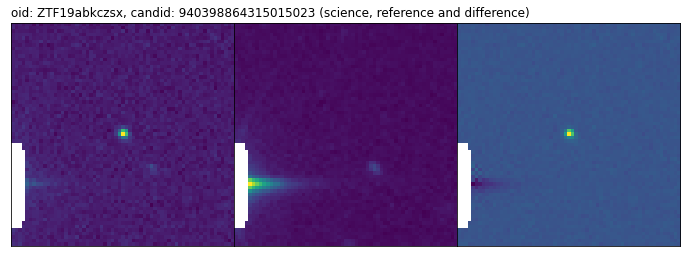

https://alerce.online/object/ZTF19aagrapo


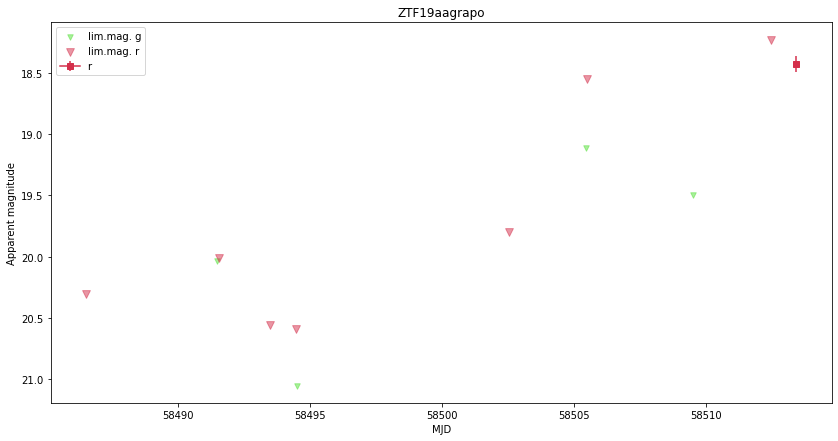

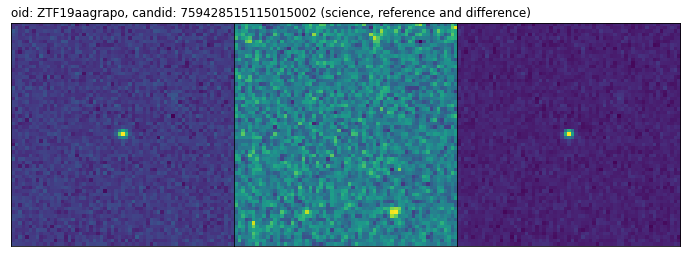

######### bogus class #########
bogus


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19abrazco,123,640,58607.486736,58717.278958,False,False,23,0.245901,0.397628,0.113766,...,58717.278958,23.962593,307.801767,24.689723,0.000102,0.000074,bogus,stamp_classifier,0.855011,corr_bulk_0.0.1
ZTF19abqgsxb,76,763,58350.423530,59231.134884,False,False,14,-0.362200,NaN,-0.058018,...,59231.134884,546.716065,11.154599,11.274965,0.000152,0.000112,bogus,stamp_classifier,0.802134,corr_bulk_0.0.1
ZTF18abjrivy,27,1479,58320.474352,59501.381493,False,False,13,1.496660,NaN,1.161702,...,59501.381493,1180.907141,26.166838,52.845026,0.000277,0.000056,bogus,stamp_classifier,0.811643,correction_1.0.6
ZTF19abrmghs,20,3133,58255.425602,59723.448854,False,False,12,NaN,NaN,NaN,...,59723.448854,909.316227,302.317926,30.100763,0.000222,0.000100,bogus,stamp_classifier,0.869887,correction_1.0.6
ZTF19abrapql,44,483,58628.459687,58717.243079,False,False,11,NaN,NaN,NaN,...,58717.243079,25.910671,305.127287,18.099124,0.000097,0.000073,bogus,stamp_classifier,0.847623,corr_bulk_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19abrdwnp,1,131,58718.141574,58718.141574,False,False,1,NaN,NaN,NaN,...,58718.141574,0.000000,239.793456,4.786166,NaN,NaN,bogus,stamp_classifier,0.827739,corr_bulk_0.0.1
ZTF19abreiqs,1,997,58718.178588,58718.178588,False,False,1,NaN,NaN,NaN,...,58718.178588,0.000000,237.622428,36.941640,NaN,NaN,bogus,stamp_classifier,0.801105,corr_bulk_0.0.1
ZTF19abrdzry,1,925,58718.158681,58718.158681,False,False,1,NaN,NaN,NaN,...,58718.158681,0.000000,217.276546,31.652209,NaN,NaN,bogus,stamp_classifier,0.829067,corr_bulk_0.0.1


https://alerce.online/object/ZTF18abivzzf


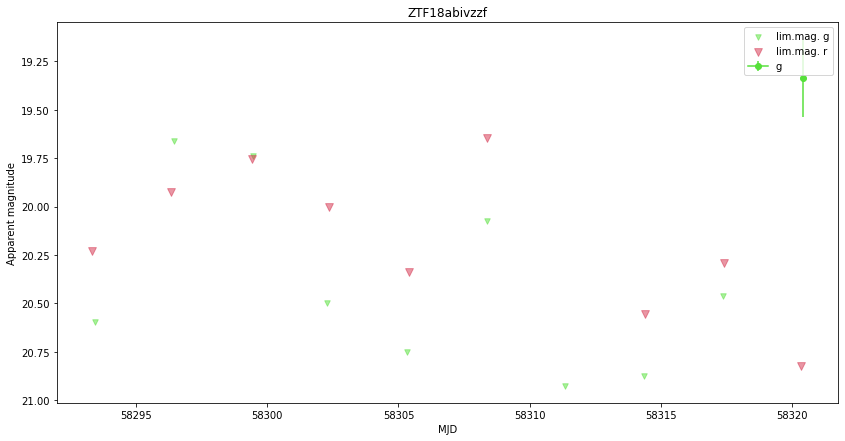

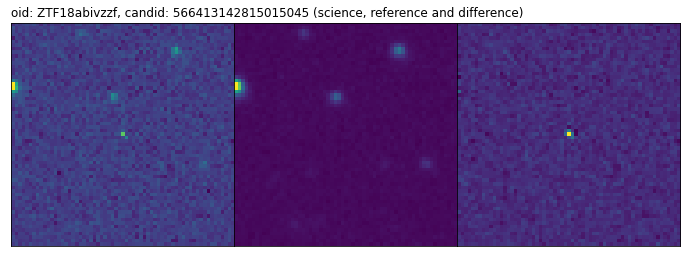

https://alerce.online/object/ZTF19abqhoiw


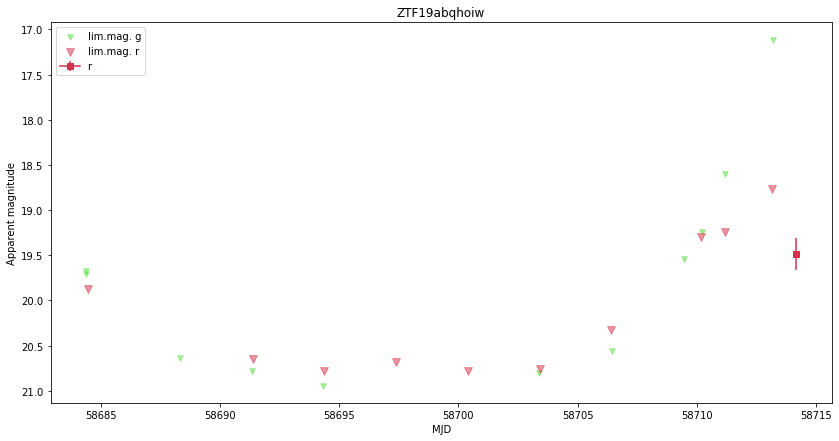

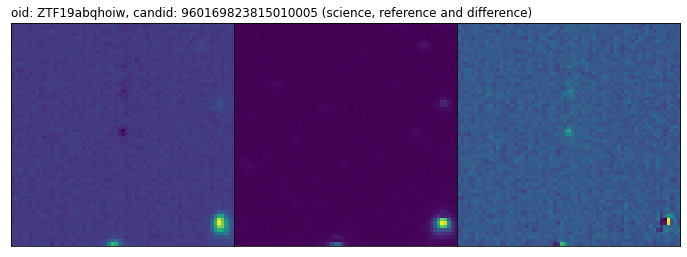

In [114]:
for cl, df in objects.items():
    print("######### "+ cl + " class #########")
    print(cl)
    display(df)
    if cl in ["asteroid", "bogus"]: # Just to have well classified samples to show
        df.sort_values(by="ndet", inplace=True)
    plot_some_LC(df, n_examples=2)

The distribution of the number of detections per class can give us insights on how well the classifier is working. For instance, for AGNs, SNe, and VS, we expect to see more than one detection for these classes. The objects belonging to these classes and have one detection could be new objects or the ones visited only once, short transients, or errors in the classification. For asteroids and bogus class, we expect to have objects with one detection only.

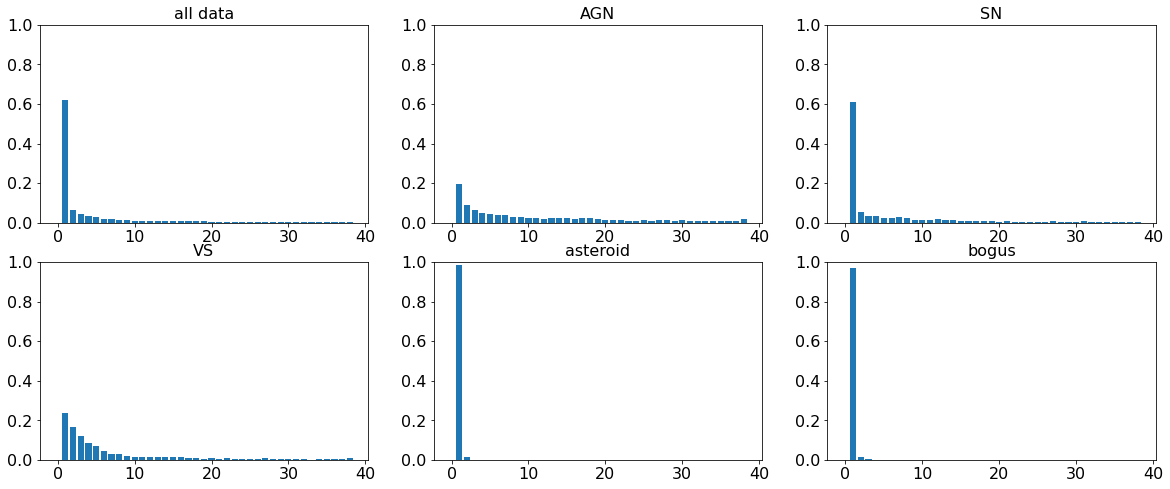

In [115]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
fig.set_facecolor('white')
bins = np.arange(0, 40)
ax = ax.flatten()
fontsize = 16

# Concatenated dataframe with all the classes
h, _ = np.histogram(pd.concat(list(objects.values()), axis=0).ndet, bins=bins, density=True)
ax[0].bar(bins[:-1], h, label="all_data")
ax[0].set_title("all data", fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[0].set_ylim([0, 1])

for i, (cl, df) in enumerate(objects.items()):
    # Histogram per class
    h, bins = np.histogram(df.ndet, bins=bins, density=True)
    ax[i+1].bar(bins[:-1], h, label=cl)
    ax[i+1].set_title(cl, fontsize=fontsize)
    ax[i+1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i+1].set_ylim([0, 1])
    
plt.show()

In our small sample we can see that most of the asteroids and bogus have only one detection, while AGNs, SNe and VS have a long tail of objects with more than one detection.

# Get a sequence of stamps <a class="anchor" id="stamp_series"></a>

In this section, we will implement a function to get a series of stamps from the alerts availables for a given object. The stamp classifier uses the first alert only, but in ALeRCE we are working to extend the stamp classifier to use a multi-stamp approach considering band g and r simultaneously. One example of this kind of classifier is the one presented in [Carrasco-Davis et al. 2019](https://iopscience.iop.org/article/10.1088/1538-3873/aaef12), where the stamps are processed by a convolutional neural network, to then use a recurrent neural network that can store previous inputs of the sequence of stamps. Then, in case you want to experiment with a sequence of stamps, here is an example:
+ We first get the detections of an object using get_detection of the ALeRCE client
+ Then we sort the values by mjd
+ The resulting dataframe uses the candidate id as index, then we use the get_stamp function for each candidate to obtain their respective stamp
+ We finally plot the stamps and return a list of stamps

In [116]:
def get_stamp_series(oid, n_stamps=5, show_stamps=False, show_LC=False):
    band_labels = {1: 'g', 2: 'r'}
    band_cmap = {"g": "viridis", "r": "inferno"}
    object_det = client.query_detections(oid, format='pandas') # Get object detections
    candids = object_det.loc[object_det.has_stamp]
    object_det = object_det.iloc[:n_stamps] # Use n stamps only
    candids = object_det.candid # Obtain the candidate id to use it in the get_stamp function
    stamps = []
    for c in candids:
        candid_stamps = client.get_stamps(oid, candid=c)
        stamps.append(candid_stamps) # Save the stamps in a list to return
    
    if show_LC:
        getObjectData(oid, doLC=True, dostamp=False) # Plot the light curve of the object
        
    if show_stamps:
        fig, ax = plt.subplots(3, n_stamps, figsize=(n_stamps*3, 10))
        fig.set_facecolor('white')
        for i, s in enumerate(stamps):
            corresponding_band = band_labels[object_det.iloc[i].fid] # Check band
            cmap = band_cmap[corresponding_band] # use a different cmap for each band
            # The get_stamp function returns a list with three images 
            # (science, reference and difference) in hdu format. Using .data we get the numpy array.
            science, ref, difference = s[0].data, s[1].data, s[2].data 
            ax[0, i].imshow(np.arcsinh(science), cmap=cmap) # Log scale for visualization
            ax[1, i].imshow(np.arcsinh(ref), cmap=cmap)
            ax[2, i].imshow(difference, cmap=cmap)
            title = "MJD " + str(np.round(object_det.iloc[i].mjd, 2)) + ", band: "+corresponding_band
            ax[0, i].set_title(title)
        ax[0, 0].set_ylabel("Science")
        ax[1, 0].set_ylabel("Reference")
        ax[2, 0].set_ylabel("Difference")
        plt.show()
    return object_det, stamps

Let's use [ZTF19acftude](https://alerce.online/object/ZTF19acftude) since it has a very nice looking SN light curve and host galaxy.

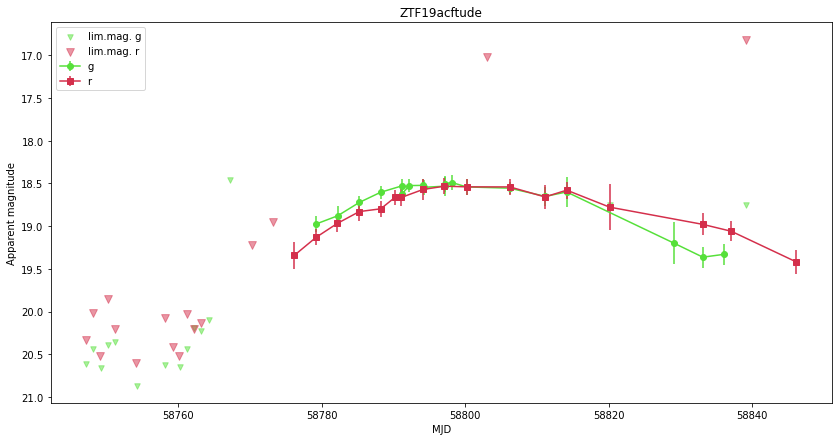

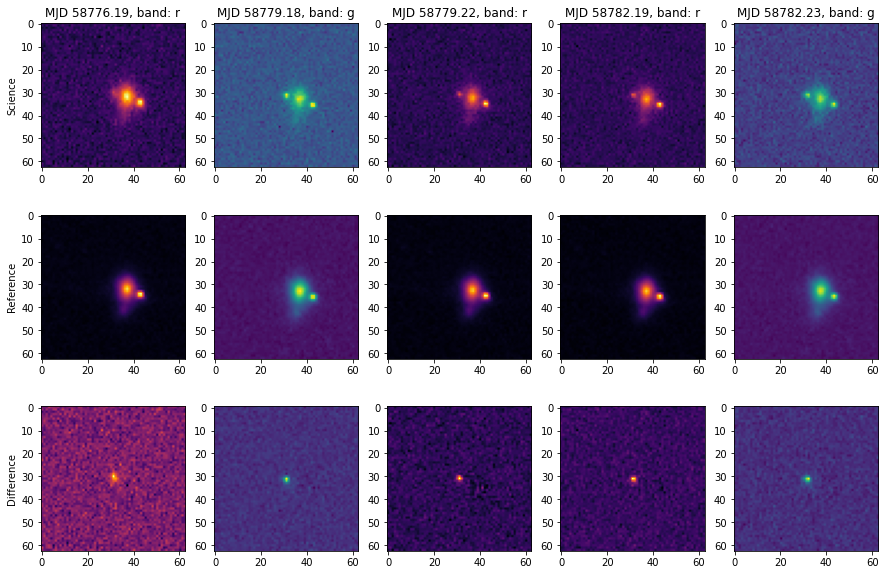

In [117]:
detections, stamps = get_stamp_series(oid="ZTF19acftude", show_stamps=True, show_LC=True)

The detections dataframe contains important information regarding the specific properties measured at a given time for the same object. For instance, the measuring time in mjd, mean and std of the position in radec, the magnitude, etc.

In [118]:
detections

,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,...,drb,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid
0,ztf,58776.193437,1022193432915015007,2,1022193432915,20.080343,1,1022,5.543976,19.341621,...,0.999900,18.9652,0.1572,645120229.0,False,False,False,bulk_1.0.0,0.0,1040123182915015002
1,ztf,58779.183681,1025183682915015015,1,1025183682915,20.761301,1,1025,6.320379,18.976433,...,1.000000,18.7278,0.0893,645120129.0,False,False,False,bulk_1.0.0,0.0,1040123182915015002
2,ztf,58779.217720,1025217712915015002,2,1025217712915,20.306961,1,1025,5.839703,19.131290,...,0.999983,19.2465,0.2135,645120229.0,False,False,False,bulk_1.0.0,0.0,1040123182915015002
3,ztf,58782.185347,1028185342915015006,2,1028185342915,20.332592,1,1028,5.764044,18.967964,...,0.999979,18.7958,0.1390,645120229.0,False,False,False,bulk_1.0.0,0.0,1040123182915015002
4,ztf,58782.226354,1028226352915015006,1,1028226352915,20.651066,1,1028,6.317516,18.879139,...,0.999999,18.5549,0.0791,645120129.0,False,False,False,bulk_1.0.0,0.0,1040123182915015002


In [119]:
detections.columns

Index(['tid', 'mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magap', 'sigmapsf', 'sigmagap', 'ra', 'dec', 'rb',
       'rbversion', 'drb', 'magapbig', 'sigmagapbig', 'rfid', 'has_stamp',
       'corrected', 'dubious', 'step_id_corr', 'phase', 'parent_candid'],
      dtype='object')

# Get spatial distribution of predictions <a class="anchor" id="spatial_distribution"></a>

One issue when training models in astronomy is the possible biases found in the training set. One of the problems we had at the beginning was the abundance of extragalactic objects predicted near the galactic plane. As mentioned in the Introduction, SNe and AGNs are less likely to be found near the galactic plane due to occlusion. We fixed this problem by adding some features to the CNN at the fully connected layers, one of the most important are the ecliptic and galactic coordinates, so let's see how they look like per class.

### Compute galactic and ecliptic coordinates
We computed the coordinates from the meanra and mean dec using the ephem python package. Here (https://rhodesmill.org/pyephem/coordinates.html) there is a more detailed tutorial of how to use this transformation between coordinates. Now, we will take our dataframes and add ecliptic and galactic latitude and longitude as columns.

In [120]:
def ecliptic_coordinates(df):
    # Define the lambda function to be applied to each row of the dataframe
    ecl = df.apply(lambda row: ephem.Ecliptic(ephem.Equatorial('%s' % (row.meanra / 15.),
                                                               '%s' % row.meandec, epoch=ephem.J2000)), axis=1)
    
    # Apply the function to each row, the result is append as a new column
    df["ecl_lat"] = ecl.apply(lambda row: np.rad2deg(row.lat))
    df["ecl_long"] = ecl.apply(lambda row: np.rad2deg(row.long))
    
    # Return the updated dataframe
    return df


def galactic_coordinates(df):
    # Define the lambda function to be applied to each row of the dataframe
    gal = df.apply(lambda row: ephem.Galactic(ephem.Equatorial('%s' % (row.meanra / 15.),
                                                               '%s' % row.meandec, epoch=ephem.J2000)), axis=1)
    # Apply the function to each row, the result is append as a new column
    df["gal_lat"] = gal.apply(lambda row: np.rad2deg(row.lat))
    df["gal_long"] = gal.apply(lambda row: np.rad2deg(row.long))
    
    # Return the updated dataframe
    return df

# For each of our dataframe corresponding to one of the classes of the stamp classifier
# we add the ecliptic and galactic coordinates
for cl, df in objects.items():
    ecl_df = ecliptic_coordinates(df)
    gal_df = galactic_coordinates(ecl_df)
    objects[cl] = gal_df

In [121]:
def plot_spatial_distribution(df, ax, index=0, cmin_val=0.1, vmax_val=5, titles="", fontsize=18, x_label=None, y_label=None):
    dims = ['gal_long', 'gal_lat'] # Let's use our new column to plot the objects
    # This is a 2D histogram of the positions of objects for each of the classes
    _, _, _, im = ax.hist2d(df[dims].values[:, 0], df[dims].values[:, 1],
                            (300, 300), cmap="viridis", vmax=vmax_val, cmin=cmin_val)
    ax.tick_params(axis='both', labelsize=fontsize-2)
    ax.set_xlim([0, 360])
    ax.set_ylim([-80, 80])
    cbar = plt.colorbar(im,ax=ax, pad=0)
    cbar.ax.tick_params(labelsize=fontsize-4)
    
    ecliptic_lat = np.zeros(500)
    ecliptic_longi = np.linspace(0, 360, num=500)
    # This auxiliary function computes the ecliptic plane by converting
    # the ecliptic latitude 0 to galactic coordinates
    # We should find many asteroids near the ecliptic
    ecliptic = SkyCoord(ecliptic_longi, ecliptic_lat, unit='deg', frame='barycentrictrueecliptic')
    galact_long, galact_lat = ecliptic.galactic.l.deg, ecliptic.galactic.b.deg
    
    ax.set_title(titles, fontsize=fontsize)
    ax.plot(galact_long, galact_lat, "ok", markersize=6)
    ax.plot(galact_long, galact_lat, "oy", markersize=4)
    if not x_label is None:
        ax.set_xlabel(x_label, fontsize=fontsize)
    if not y_label is None:
        ax.set_ylabel(y_label, fontsize=fontsize)
    
    return ax

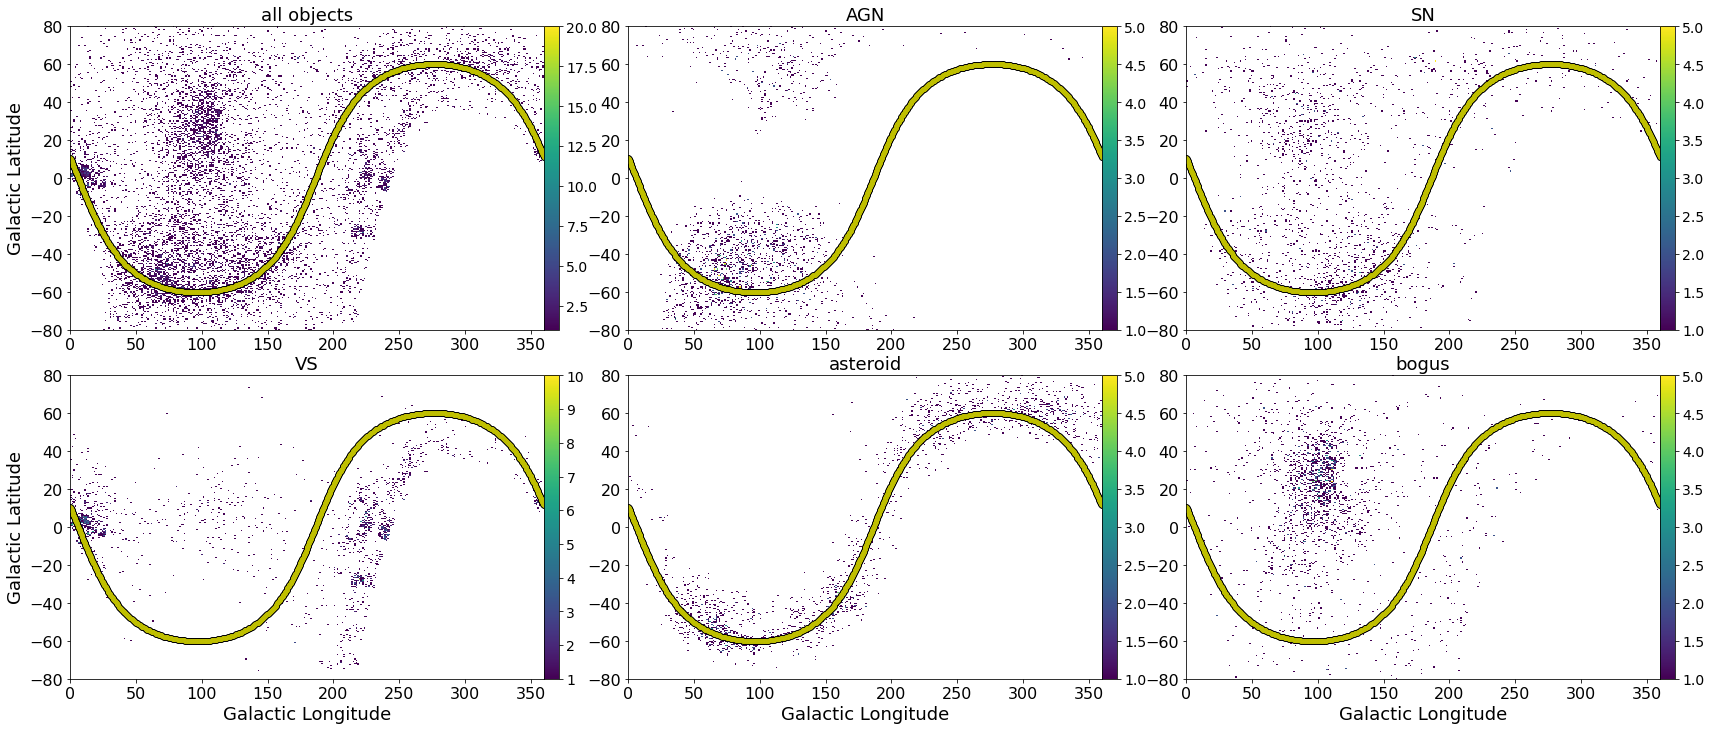

In [122]:
fig, ax = plt.subplots(2, 3, figsize=(3*10, 2*6))
fig.set_facecolor('white')
plt.subplots_adjust(wspace=0.0, hspace=0.15)
ax = ax.flatten() # A trick to iterate over the axis of a subplot array
titles = ["all objects", ] + list(objects.keys())
# This is just to control the saturation of the histograms, the larger
# the number, the larger the amount of objects needed in the same location to increase the color scale
max_count_per_class = dict(zip(titles, [20, 5, 5, 10, 5, 5])) 

for i in range(6):
    x_label = None
    y_label = None
    if i == 0:
        df = pd.concat(list(objects.values()), axis=0)
    else:
        df = list(objects.values())[i-1]
    
    if i in [0, 3]:
        y_label = "Galactic Latitude"
    if i in [3, 4, 5]:
        x_label = "Galactic Longitude"
    ax[i] = plot_spatial_distribution(df, ax[i], titles=titles[i], vmax_val=max_count_per_class[titles[i]], x_label=x_label, y_label=y_label)
plt.show()

Here us the spatial distribution for the unlabeled data, and distribution of predictions per class. The colorbar indicates the density of points. The ecliptic is shown with a yellow line with black edges. The distributions are shown as a 2d histogram of density of alerts. Extragalactic sources (SNe and AGNs) are found outside the Galactic plane. On the contrary, VS are concentrated in the Galactic plane. Asteroids are near the ecliptic.

### Probabilities per class as a function of the position

Even though most of the objects per class lie in a reasonable position according to their nature, there are some errors or contamination between classes. It is interesting to see how certain is the stamp classifier for each class depending on their position, so let’s plot the probability of each object belonging to each class in the same galactic coordinates projection. We only have to modify our previous “plot_spatial_distribution” function to make a scatter plot instead of the 2d histogram. We will fill each scatter dot with a colormap and size that reflects their probability.

In [123]:
def plot_spatial_probabilities(df, ax, index=0, cmin_val=0.1, vmax_val=5, titles="", fontsize=18, x_label=None, y_label=None):
    # We sort the rows of the dataframe first in order to reduces biases when "painting" the plot with the scatter
    df = df.sample(frac=1) 
    dims = ['gal_long', 'gal_lat'] # Let's use our new column to plot the objects
    # We will use the normalized probabilities (between 0 and 1) to scale the size of each dot according 
    # the their probability of belonging to the respective class
    normalized_probabilities_per_class = df["probability"].values - np.amin(df["probability"].values)
    normalized_probabilities_per_class = normalized_probabilities_per_class/np.amax(normalized_probabilities_per_class)
    # Variable size dots for the scatter plot
    variable_sizes = 10 + normalized_probabilities_per_class*100
    color_map = plt.cm.get_cmap('viridis')
    im = ax.scatter(df[dims].values[:, 0], df[dims].values[:, 1], c=df["probability"].values, cmap=color_map,
                   s=variable_sizes, alpha=0.7)
    ax.tick_params(axis='both', labelsize=fontsize-2)
    ax.set_xlim([0, 360])
    ax.set_ylim([-80, 80])
    cbar = plt.colorbar(im,ax=ax, pad=0)
    cbar.ax.tick_params(labelsize=fontsize-4)
    
    ecliptic_lat = np.linspace(0, 0, num=500)
    ecliptic_longi = np.linspace(0, 360, num=500)
    # This auxiliary function computes the ecliptic plane by converting
    # the ecliptic latitude 0 to galactic coordinates
    ecliptic = SkyCoord(ecliptic_longi, ecliptic_lat, unit='deg', frame='barycentrictrueecliptic')
    galact_long, galact_lat = ecliptic.galactic.l.deg, ecliptic.galactic.b.deg
    
    ax.set_title(titles, fontsize=fontsize)
    ax.plot(galact_long, galact_lat, "ok", markersize=6)
    ax.plot(galact_long, galact_lat, "oy", markersize=4)
    
    if not x_label is None:
        ax.set_xlabel(x_label, fontsize=fontsize)
    if not y_label is None:
        ax.set_ylabel(y_label, fontsize=fontsize)
    
    return ax

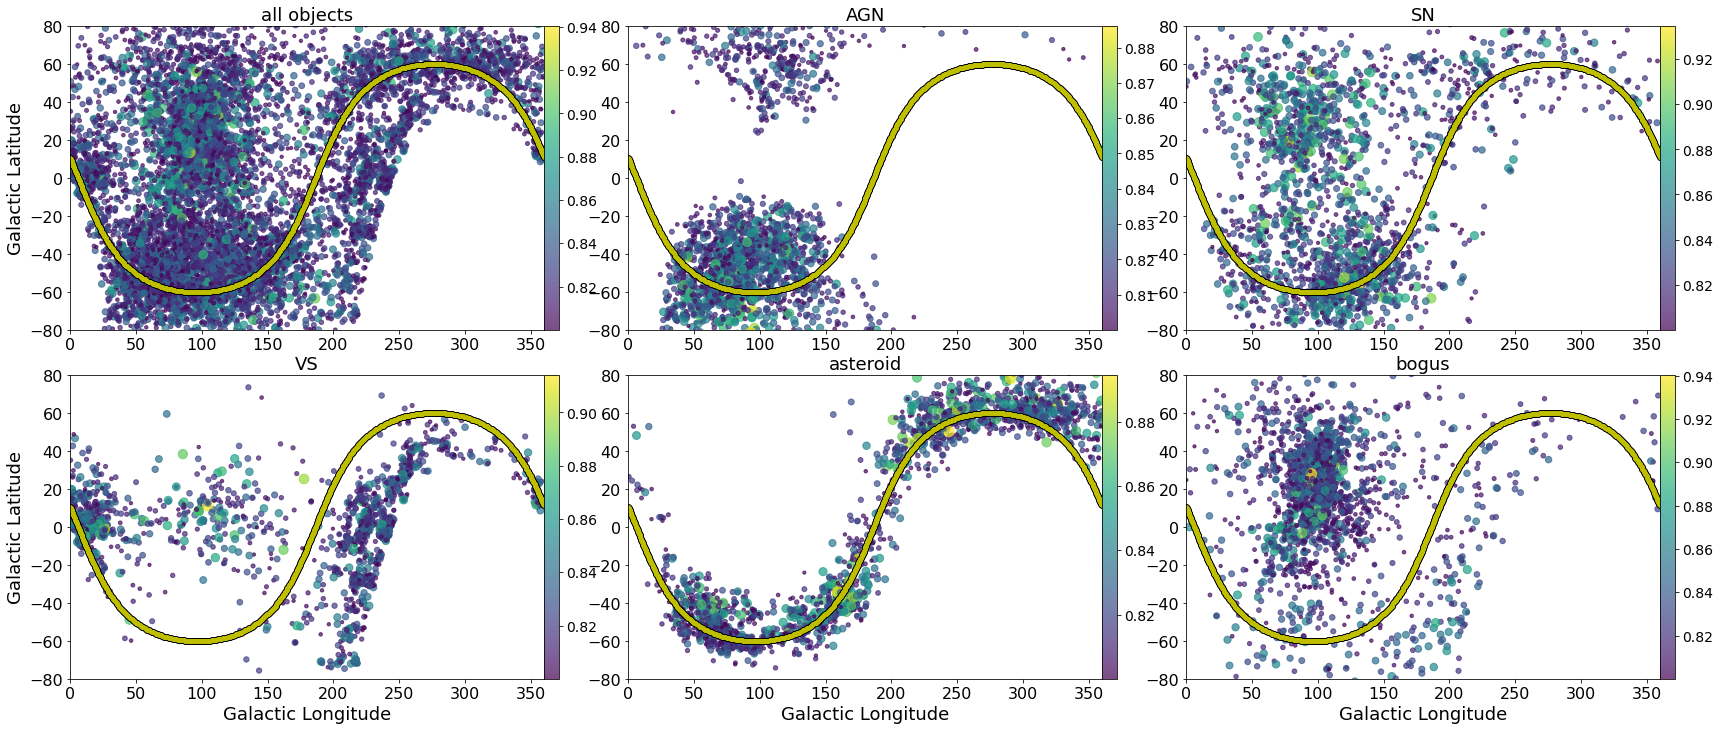

In [124]:
fig, ax = plt.subplots(2, 3, figsize=(3*10, 2*6))
fig.set_facecolor('white')
plt.subplots_adjust(wspace=0.0, hspace=0.15)
ax = ax.flatten() # A trick to iterate over the axis of a subplot array
titles = ["all objects", ] + list(objects.keys())

for i in range(6):
    x_label = None
    y_label = None
    if i == 0:
        df = pd.concat(list(objects.values()), axis=0)
    else:
        df = list(objects.values())[i-1]
    
    if i in [0, 3]:
        y_label = "Galactic Latitude"
    if i in [3, 4, 5]:
        x_label = "Galactic Longitude"
    
    ax[i] = plot_spatial_probabilities(df, ax[i], titles=titles[i], vmax_val=max_count_per_class[titles[i]], x_label=x_label, y_label=y_label)
plt.show()

For the SN class, the stamp classifier seems to be more confident about the prediction further from the ecliptic, there is a large blob of green-yellow dots at around (40, 120), while darker blobs near the ecliptic, meaning less confidence in the prediction. We can also see a greener blob near the center of the galaxy in the case of variable stars. In addition, it is also important to know the relative confidence between classes, some classes are harder to classify than others as you can see in the “all objects” scatter. Now, we will plot the distribution of probabilities per class.

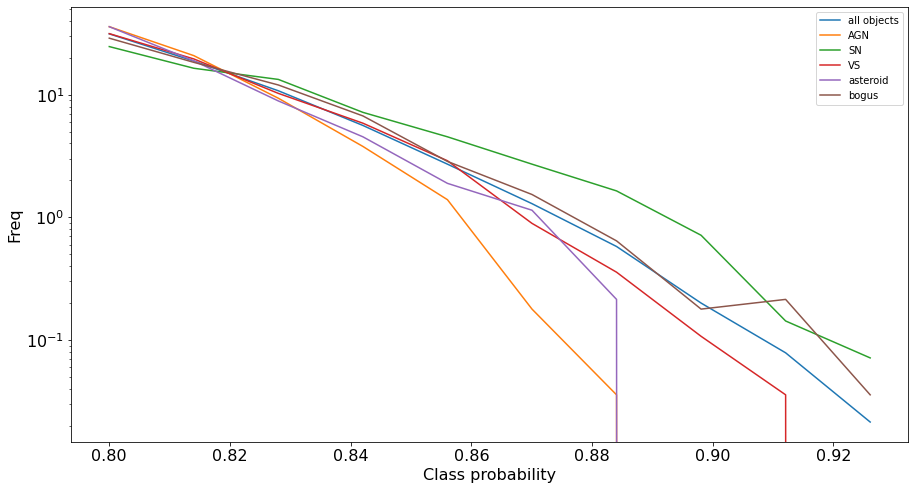

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
fig.set_facecolor('white')
for i in range(6):
    if i == 0:
        df = pd.concat(list(objects.values()), axis=0)
        h, bins = np.histogram(df.probability.values, bins=10, density=True)
    else:
        df = list(objects.values())[i-1]
        h, bins = np.histogram(df.probability.values, bins=bins, density=True)
    ax.plot(bins[:-1], h, label=titles[i])
    
plt.legend()
ax.set_xlabel("Class probability", fontsize=16)
ax.set_ylabel("Freq", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_yscale('log')
plt.show()